In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-building-safety-under-the-earthquake/sample_submission.csv
/kaggle/input/predict-the-building-safety-under-the-earthquake/train.csv
/kaggle/input/predict-the-building-safety-under-the-earthquake/test.csv


In [3]:
sample_submission_data = pd.read_csv("/kaggle/input/predict-the-building-safety-under-the-earthquake/sample_submission.csv")
train = pd.read_csv("/kaggle/input/predict-the-building-safety-under-the-earthquake/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-building-safety-under-the-earthquake/test.csv")

In [4]:
print("Train Features:")
print(train.columns.to_list)
print("Test Columns:")
print(test.columns.to_list)

Train Features:
<bound method IndexOpsMixin.tolist of Index(['Column fy Mpa', 'Beam fy Mpa', 'Columns 1-3 I mm4*10^6',
       'Columns 4-6 I mm4*10^6', 'Columns 1-3 A mm2', 'Columns 4-6 A mm2',
       'Beam I mm4*10^6', 'Spans', 'Number of floors', 'Floor height m',
       'Span width m', 'LLRS tributary width m', 'Floor mass kg',
       'Facade Load kN/m', 'PGA g', 'Magnitude', 'Distance to fault km',
       'Period s', 'Max drift mm', 'Final Dead Load', 'Final Live Load',
       'soil_class__B', 'soil_class__C'],
      dtype='object')>
Test Columns:
<bound method IndexOpsMixin.tolist of Index(['Column fy Mpa', 'Beam fy Mpa', 'Columns 1-3 I mm4*10^6',
       'Columns 4-6 I mm4*10^6', 'Columns 1-3 A mm2', 'Columns 4-6 A mm2',
       'Beam I mm4*10^6', 'Spans', 'Number of floors', 'Floor height m',
       'Span width m', 'LLRS tributary width m', 'Floor mass kg',
       'Facade Load kN/m', 'PGA g', 'Magnitude', 'Distance to fault km',
       'Period s', 'Final Dead Load', 'Final Live Lo

## Size of the training and Test data

In [5]:
train.shape

(2922, 23)

In [6]:
test.shape

(325, 22)

In [7]:
train['Max drift mm'].describe()

count    2922.000000
mean       21.920161
std        22.225221
min         0.132411
25%         7.339454
50%        15.378362
75%        29.595909
max       275.706598
Name: Max drift mm, dtype: float64

In [8]:
train.isnull().sum()

Column fy Mpa             0
Beam fy Mpa               0
Columns 1-3 I mm4*10^6    0
Columns 4-6 I mm4*10^6    0
Columns 1-3 A mm2         0
Columns 4-6 A mm2         0
Beam I mm4*10^6           0
Spans                     0
Number of floors          0
Floor height m            0
Span width m              0
LLRS tributary width m    0
Floor mass kg             0
Facade Load kN/m          0
PGA g                     0
Magnitude                 0
Distance to fault km      0
Period s                  0
Max drift mm              0
Final Dead Load           0
Final Live Load           0
soil_class__B             0
soil_class__C             0
dtype: int64

#### Dist of target variable

<AxesSubplot:>

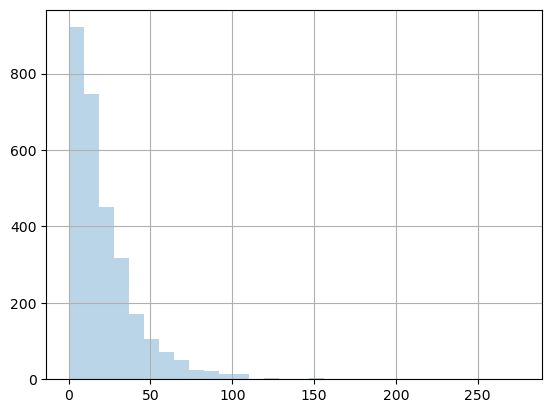

In [9]:
train['Max drift mm'].hist(bins=30, alpha=0.3)

**Distribution: Skewed**

<AxesSubplot:>

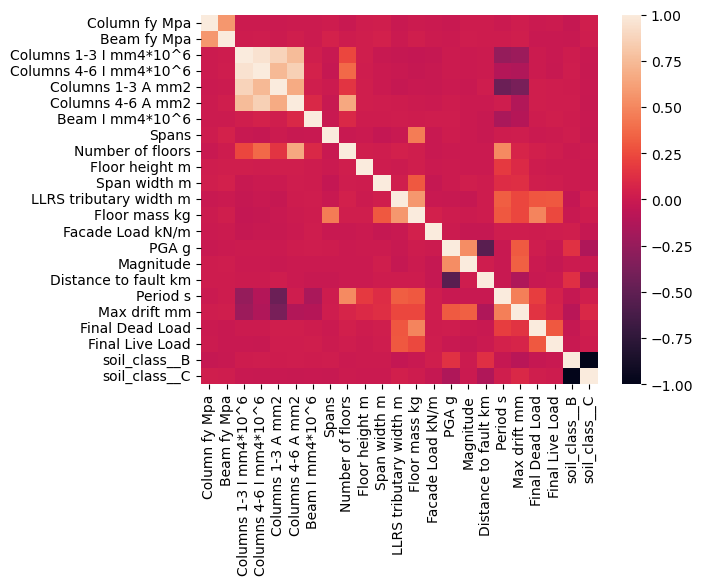

In [10]:
import seaborn as sns

sns.heatmap(train.corr())

In [11]:
import numpy as np
import pandas as pd

# create correlation  matrix
corr_matrix = train.corr().abs()

# mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

tri_df = corr_matrix.mask(mask)

## Removing Highly Correlated Columns

In [12]:
to_drop = [c for c in tri_df.columns if any(tri_df[c]>0.95)]

print(to_drop)

['Columns 1-3 I mm4*10^6', 'soil_class__B']


In [13]:
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)


In [14]:
train.columns

Index(['Column fy Mpa', 'Beam fy Mpa', 'Columns 4-6 I mm4*10^6',
       'Columns 1-3 A mm2', 'Columns 4-6 A mm2', 'Beam I mm4*10^6', 'Spans',
       'Number of floors', 'Floor height m', 'Span width m',
       'LLRS tributary width m', 'Floor mass kg', 'Facade Load kN/m', 'PGA g',
       'Magnitude', 'Distance to fault km', 'Period s', 'Max drift mm',
       'Final Dead Load', 'Final Live Load', 'soil_class__C'],
      dtype='object')

In [15]:
train.shape, test.shape

((2922, 21), (325, 20))

## Evaluation Metric

**The evaluation metric for this competition is Mean Absolute Percentage Error (MAPE). Therefore, the interpretation of this error in the case of this competition will be "How many percentages my prediction deviates from real interstorey displacements on average".**

Columns

Column fy Mpa - the yielding limit of columns' steel material

Beam fy Mpa - the yielding limit of beams' steel material

Columns 1-3 I mm4*10^6 - a moment of inertia of the bottom columns' (1-3 floors) cross-section

Columns 4-6 I mm4*10^6 - a moment of inertia of the upper columns' (4-6 floors) cross-section

Columns 1-3 A mm2 - an area of the bottom (1-3 floors) columns' cross-section

BColumns 4-6 A mm2 - an area of the upper (1-3 floors) columns' cross-section

Beam I mm4*10^6 - a moment of inertia of the beams' columns' cross-section

Spans - frame's number of spans

Number of floors - frame's number of floors

Floor height m - the height of each floor

Span width m - the width of each span

LLRS tributary width m - seismic tributary width of lateral load resisting system under 

consideration

Floor mass kg - the mass of one floor (excluding the frame's self-weight)

Facade Load kN/m - the gravity load from facade acting on beams

PGA g - peak ground acceleration of the acting ground motion

Magnitude - the magnitude of the acting ground motion

Distance to fault km - distance to fault of the acting ground motion

Period s - structural period (fundamental)

Max drift mm - maximum interstorey displacement (this is a value you need to predict)

Final Dead Load - acting dead load on beams (excluding self-weight) considering gravity loads' 
tributary width

Final Live Load - acting live load on beams considering gravity loads' tributary width

soil_class__B - 1 is soil class of acting ground motion is B (according to Eurocode 8), 0 otherwise

soil_class__C - 1 is soil class of acting ground motion is C (according to Eurocode 8), 0 otherwise

## Feature Engineering

In [16]:
train['id'] = train.index + 1

In [17]:
train['id'][-1:]

2921    2922
Name: id, dtype: int64

In [18]:
test['id'] = test.index + 2923

In [19]:
test['id'][0]

2923

In [20]:
test['id'][-1:]

324    3247
Name: id, dtype: int64

In [21]:
data = pd.concat([train, test])

In [22]:
# getting total area of column cross-section 

data['total_col_area_xs'] = data['Columns 1-3 A mm2'] + data['Columns 4-6 A mm2']

In [23]:
# Getting total height of the building

data['total_height'] = data['Number of floors'] + data['Floor height m']

In [24]:
data = data.drop(['Columns 1-3 A mm2', 'Columns 4-6 A mm2', 'Number of floors', 'Floor height m'], axis=1)

In [25]:
data.head()

,Column fy Mpa,Beam fy Mpa,Columns 4-6 I mm4*10^6,Beam I mm4*10^6,Spans,Span width m,LLRS tributary width m,Floor mass kg,Facade Load kN/m,PGA g,Magnitude,Distance to fault km,Period s,Max drift mm,Final Dead Load,Final Live Load,soil_class__C,id,total_col_area_xs,total_height
0,275.0,235.0,10.330,1119.0,5.0,8.0,17.5,271342.1700,3.0,0.171,6.00,17.28,5.178486,35.052122,10.5,7.0,1.0,1,7019.0,8.0
1,235.0,235.0,182.600,117.7,3.0,8.0,20.0,196435.0080,4.0,0.150,6.33,18.96,4.539964,89.310331,12.0,8.0,1.0,2,23690.0,10.0
2,275.0,235.0,0.000,117.7,6.0,5.0,10.0,218011.8600,1.0,0.171,6.00,17.28,1.412026,31.485753,15.0,10.0,1.0,3,13347.0,7.0
3,235.0,235.0,6.062,920.8,6.0,5.0,4.0,43031.3400,1.0,0.283,7.28,19.74,2.490511,27.250323,4.0,10.0,1.0,4,5676.0,9.0
4,355.0,355.0,0.000,920.8,3.0,6.0,2.0,25419.0816,4.0,0.171,6.00,17.28,0.313426,5.109617,8.0,4.0,1.0,5,14276.0,6.0


In [26]:
data.shape

(3247, 20)

In [27]:
new_train = data[data['id'].isin(train['id'])]
new_test = data[data['id'].isin(test['id'])]

In [28]:
train = new_train
test = new_test

In [29]:
train.shape, test.shape

((2922, 20), (325, 20))

In [30]:
train.head()

,Column fy Mpa,Beam fy Mpa,Columns 4-6 I mm4*10^6,Beam I mm4*10^6,Spans,Span width m,LLRS tributary width m,Floor mass kg,Facade Load kN/m,PGA g,Magnitude,Distance to fault km,Period s,Max drift mm,Final Dead Load,Final Live Load,soil_class__C,id,total_col_area_xs,total_height
0,275.0,235.0,10.330,1119.0,5.0,8.0,17.5,271342.1700,3.0,0.171,6.00,17.28,5.178486,35.052122,10.5,7.0,1.0,1,7019.0,8.0
1,235.0,235.0,182.600,117.7,3.0,8.0,20.0,196435.0080,4.0,0.150,6.33,18.96,4.539964,89.310331,12.0,8.0,1.0,2,23690.0,10.0
2,275.0,235.0,0.000,117.7,6.0,5.0,10.0,218011.8600,1.0,0.171,6.00,17.28,1.412026,31.485753,15.0,10.0,1.0,3,13347.0,7.0
3,235.0,235.0,6.062,920.8,6.0,5.0,4.0,43031.3400,1.0,0.283,7.28,19.74,2.490511,27.250323,4.0,10.0,1.0,4,5676.0,9.0
4,355.0,355.0,0.000,920.8,3.0,6.0,2.0,25419.0816,4.0,0.171,6.00,17.28,0.313426,5.109617,8.0,4.0,1.0,5,14276.0,6.0


In [31]:
test.head()

,Column fy Mpa,Beam fy Mpa,Columns 4-6 I mm4*10^6,Beam I mm4*10^6,Spans,Span width m,LLRS tributary width m,Floor mass kg,Facade Load kN/m,PGA g,Magnitude,Distance to fault km,Period s,Max drift mm,Final Dead Load,Final Live Load,soil_class__C,id,total_col_area_xs,total_height
0,355.0,355.0,4221.000,231.30,4.0,3.0,2.5,17579.6280,4.0,0.354,6.50,15.82,0.216653,NaN,7.5,5.0,0.0,2923,66738.0,7.0
1,355.0,235.0,0.000,482.00,5.0,3.0,3.0,15968.5020,0.0,0.140,5.90,25.50,0.076358,NaN,9.0,6.0,1.0,2924,21176.0,5.0
2,235.0,235.0,6.062,1752.00,1.0,3.0,8.0,10531.4616,2.0,0.283,7.28,19.74,2.384245,NaN,8.0,12.0,1.0,2925,5676.0,9.0
3,355.0,235.0,0.000,231.30,2.0,8.0,14.0,165958.2144,4.0,0.300,6.60,10.27,0.337537,NaN,21.0,7.0,0.0,2926,17803.0,4.0
4,275.0,235.0,0.000,13.17,1.0,3.0,7.5,4496.8770,0.0,0.150,6.20,13.91,0.180089,NaN,1.5,6.0,0.0,2927,21176.0,5.0


In [32]:
test = test.drop(['Max drift mm'], axis=1)

In [33]:
test.shape

(325, 19)

In [34]:
X = train.drop(['Max drift mm'], axis=1)
y = train['Max drift mm']

In [35]:
X.shape, y.shape

((2922, 19), (2922,))

## Validation 

In [36]:
# Models

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
rf_best = RandomForestRegressor(max_depth=13, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=650)

scores = cross_val_score(rf_best, X, y, cv=5)

print(scores)
print(np.mean(scores))
print(np.mean(scores) + np.std(scores))

[0.86330427 0.86418874 0.76262086 0.88693742 0.86296839]
0.8480039357014284
0.8916526893555532


## Model Predictions

In [39]:
rf_best.fit(X, y)

rf_pred = rf_best.predict(test)
rf_pred[:10]

array([ 5.71515718,  0.34644435, 41.60851044, 16.29868878,  2.38569535,
       42.48418319, 75.25546827, 12.94515867, 24.78199515, 28.62969213])

## Submission Preparation

In [40]:
submission = test

submission['Max drift mm'] = rf_pred
submission['Index'] = submission.index 
submission[['Index', 'Max drift mm']].to_csv('submission.csv', index=False)